In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.reuters.load_data()

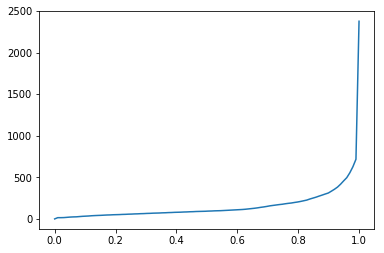

In [3]:
data_input_len_quantile_x = np.linspace(0, 1, num=100)
data_input_len_quantile_y = np.quantile(
    [len(x) for x in X_train] + [len(x) for x in X_test], data_input_len_quantile_x)
plt.plot(data_input_len_quantile_x, data_input_len_quantile_y)
plt.show()

In [4]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=64, padding='post', truncating='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=64, padding='post', truncating='post')
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((8982, 64), (8982,), (2246, 64), (2246,))

In [5]:
data_input_dim = max(np.max(X_train), np.max(X_test)) + 1
data_input_dim

30979

In [6]:
data_output_dim = max(np.max(Y_train), np.max(Y_test)) + 1
data_output_dim

46

In [7]:
class AssoLSTMCell(keras.layers.Layer):
    
    def __init__(self,
                 units,
                 redundancy,
                 enable_hidden_to_update=False,
                 **kwargs):
        if units % 2 != 0:
            raise Exception('units is requried to be even')
        self.units = units
        self.redundancy = redundancy
        self.enable_hidden_to_update = enable_hidden_to_update
        self.state_size = units, units*redundancy
        self.permuatation = self.__permuatation()
        super().__init__(**kwargs)
    
    def __permuatation(self):
        import numpy as np
        space = np.arange(self.units//2)
        perm = np.random.choice(space,size=(
            self.redundancy,self.units//2),replace=True)
        return perm
    
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(self.units+input_shape[-1], (self.units//2)*7),
            initializer='glorot_normal', name='kernel')
        self.bias = self.add_weight(
            shape=((self.units//2)*7,),
            initializer='zeros', name='bias')
        self.kernel_update = self.add_weight(
            shape=((
                self.units if self.enable_hidden_to_update else 0
                ) + input_shape[-1], self.units),
            initializer='glorot_normal', name='kernel_update')
        self.bias_update = self.add_weight(
            shape=(self.units,),
            initializer='zeros', name='bias_update')
        super().build(input_shape)
    
    def call(self, inputs, states):
        
        def bound(x):
            norm = K.sqrt(K.sum(K.square(x),axis=-1,keepdims=True))
            norm = K.clip(norm, 1., None)
            return x / norm
        
        def complex_mul(x, y):
            return K.stack([
                x[:,:,:,0]*y[:,:,:,0] - \
                x[:,:,:,1]*y[:,:,:,1],
                x[:,:,:,0]*y[:,:,:,1] + \
                x[:,:,:,1]*y[:,:,:,0]], axis=-1)
        
        hidden, holographic = states
        holographic = K.reshape(
            holographic, (-1,self.redundancy,self.units//2,2))
        
        hidden = K.concatenate([inputs, hidden])
        update = (hidden \
            if self.enable_hidden_to_update else inputs
            ) @ self.kernel_update + self.bias_update
        update = K.reshape(update, (-1,self.units//2,2))
        update = bound(update)
        gates = hidden @ self.kernel + self.bias
        gates_f = gates[:,:self.units//2]
        gates_f = K.expand_dims(gates_f)
        gates_f = K.sigmoid(gates_f)
        gates_i = gates[:,self.units//2:(self.units//2)*2]
        gates_i = K.expand_dims(gates_i)
        gates_i = K.sigmoid(gates_i)
        gates_o = gates[:,(self.units//2)*2:(self.units//2)*3]
        gates_o = K.expand_dims(gates_o)
        gates_o = K.sigmoid(gates_o)
        key_i = gates[:,(self.units//2)*3:(self.units//2)*5]
        key_i = K.reshape(key_i, (-1,self.units//2,2))
        key_i = bound(key_i)
        key_o = gates[:,(self.units//2)*5:(self.units//2)*7]
        key_o = K.reshape(key_o, (-1,self.units//2,2))
        key_o = bound(key_o)
        
        perm = tf.constant(self.permuatation,dtype=tf.int32)
        perm = tf.expand_dims(perm,axis=0)
        perm = tf.tile(perm, (K.shape(inputs)[0],1,1))
        perm = tf.stack([
            tf.tile(tf.reshape(tf.range(
                K.shape(inputs)[0]),(-1,1,1)),
                    (1,self.redundancy,self.units//2)),
            perm],axis=-1)
        key_i = tf.gather_nd(key_i, perm)
        key_o = tf.gather_nd(key_o, perm)
        
        update = gates_i * update
        update = K.expand_dims(update,axis=1)
        update = complex_mul(key_i, update)
        holographic = K.expand_dims(gates_f,axis=1) * \
            holographic + update
        
        hidden = complex_mul(key_o, holographic)
        hidden = K.mean(hidden, axis=1, keepdims=False)
        hidden = bound(hidden) * gates_o
        hidden = K.reshape(hidden, (-1,self.units))
        
        return hidden, [hidden, K.reshape(
            holographic,(-1,self.redundancy*self.units))]
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
X = X_inputs = keras.layers.Input((None,), dtype='int32')
X = keras.layers.Embedding(data_input_dim, 16, mask_zero=True)(X)
X = keras.layers.RNN(AssoLSTMCell(32, 16))(X)
X = keras.layers.Dense(data_output_dim, activation='softmax')(X)
M = keras.Model(X_inputs, X)
M.compile('nadam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 16)          495664    
_________________________________________________________________
rnn_1 (RNN)                  (None, 32)                6032      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                1518      
Total params: 503,214
Trainable params: 503,214
Non-trainable params: 0
_________________________________________________________________


In [9]:
M.fit(X_train, Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=50, callbacks=[
    keras.callbacks.ReduceLROnPlateau(verbose=1)
])

Train on 8982 samples, validate on 2246 samples
Epoch 1/50
8982/8982 [==============================] - 33s 4ms/step - loss: 3.0105 - acc: 0.3103 - val_loss: 2.1919 - val_acc: 0.3642
Epoch 2/50
8982/8982 [==============================] - 30s 3ms/step - loss: 2.0172 - acc: 0.4158 - val_loss: 1.9131 - val_acc: 0.5178
Epoch 3/50
8982/8982 [==============================] - 30s 3ms/step - loss: 1.7233 - acc: 0.5327 - val_loss: 1.7453 - val_acc: 0.5441
Epoch 4/50
8982/8982 [==============================] - 30s 3ms/step - loss: 1.5712 - acc: 0.5538 - val_loss: 1.7249 - val_acc: 0.5454
Epoch 5/50
8982/8982 [==============================] - 30s 3ms/step - loss: 1.4739 - acc: 0.5684 - val_loss: 1.7134 - val_acc: 0.5650
Epoch 6/50
8982/8982 [==============================] - 30s 3ms/step - loss: 1.4078 - acc: 0.6011 - val_loss: 1.6757 - val_acc: 0.5744
Epoch 7/50
8982/8982 [==============================] - 30s 3ms/step - loss: 1.3525 - acc: 0.6209 - val_loss: 1.6580 - val_acc: 0.5819
Epoch 8